In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import nltk
import sklearn
import wordcloud
from wordcloud import WordCloud
import contractions
import re
import pickle
import string

In [2]:
df = pd.read_csv('Multi-class dataset/train.tsv', sep = '\t', header = 0)
df_test = pd.read_csv('Multi-class dataset/test.tsv', sep = '\t', header = 0)

The dataset consists of words and phrases taken from Rotten Tomatoes reviews along with a sentiment classification ranging from 0-4 which is defined as: <br />
0 - negative <br/>
1 - somewhat negative <br/>
2 - neutral <br/>
3 - somewhat positive <br/>
4 - positive 

In [3]:
(df.head()), (df.tail())

(   PhraseId  SentenceId                                             Phrase  \
 0         1           1  A series of escapades demonstrating the adage ...   
 1         2           1  A series of escapades demonstrating the adage ...   
 2         3           1                                           A series   
 3         4           1                                                  A   
 4         5           1                                             series   
 
    Sentiment  
 0          1  
 1          2  
 2          2  
 3          2  
 4          2  ,
         PhraseId  SentenceId                     Phrase  Sentiment
 156055    156056        8544                  Hearst 's          2
 156056    156057        8544  forced avuncular chortles          1
 156057    156058        8544         avuncular chortles          3
 156058    156059        8544                  avuncular          2
 156059    156060        8544                   chortles          2)

The dataset is made from 8544 reviews of varying sentiment further divided into 156060 phrases. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

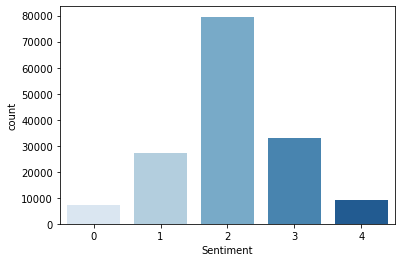

In [5]:
sns.countplot(x = df.Sentiment, palette = 'Blues')

The distribution of data between various sentiment labels is very skewed with over 50% of the phrases classifies as 'neutral'.<br/>
Hence, in this case, accuracy cannot be used as a metric for classification models on this dataset. So I shall be using the F1 score as the metric since since it takes into account both precision and recall. 

In [6]:
df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

No null values present

In [7]:
for index, text in enumerate(df['Phrase'][79:83]):
    print(text)

worth
seeking
Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .
Even fans of Ismail Merchant 's work


Cleaning the text in the dataframe:

In [8]:
def remove_numbers(text):
    re.sub('\w*\d+\w*', '', text, count = -1)
    return text

def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text) #Removes punctuations
    re.sub(' +',' ',text) #Removes extra whitespace
    return text

In [9]:
for ind in df.index:
    review = df['Phrase'][ind]
    contractions.fix(review)
    review = remove_numbers(review)
    review = remove_punctuation(review)
    df['Phrase'][ind] = review

<ipython-input-9-ff50701ae5a4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Phrase'][ind] = review


In [10]:
for ind in df_test.index:
    review = df_test['Phrase'][ind]
    contractions.fix(review)
    review = remove_numbers(review)
    review = remove_punctuation(review)
    df_test['Phrase'][ind] = review

<ipython-input-10-6d4c96816f28>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Phrase'][ind] = review


In [11]:
for index, text in enumerate(df['Phrase'][79:83]):
    print(text)

worth
seeking
Even fans of Ismail Merchant s work  I suspect  would have a hard time sitting through this one 
Even fans of Ismail Merchant s work


Dividing data into testing and training data

In [12]:
X = df.Phrase
y = df.Sentiment

In [13]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)

Plotting y_test and y_train in order to ensure that the data-split is stratified

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

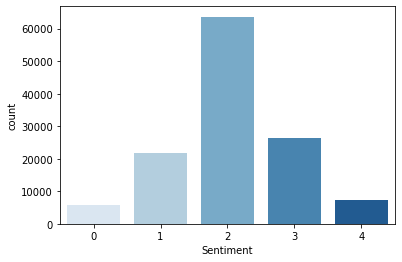

In [14]:
sns.countplot(x=y_train, palette = 'Blues')

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

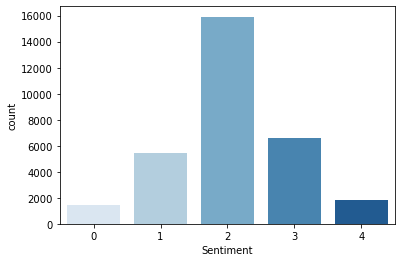

In [15]:
sns.countplot(x=y_test, palette = 'Blues')

Using TF-IDF Vectorizer and applying multiple versions of the Naive-Bayes Classifier

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
vector_train = vec.fit_transform(X_train)
vector_test = vec.transform(X_test)

In [17]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.metrics import f1_score

In [18]:
bnbclf = BernoulliNB()
bnbclf.fit(X = vector_train, y = y_train)
print(f"Bernoulli Score: {f1_score(y_true = y_test, y_pred = bnbclf.predict(vector_test), average = 'weighted')}")

Bernoulli Score: 0.5687350876815177


In [19]:
mnbclf = MultinomialNB()
mnbclf.fit(X = vector_train, y = y_train)
print(f"Multinomial Score: {f1_score(y_true = y_test, y_pred = mnbclf.predict(vector_test), average = 'weighted')}")

Multinomial Score: 0.5373434291497399


In [20]:
bnbclf = BernoulliNB()
bnbclf.fit(X = vector_train, y = y_train)
print(f"Bernoulli Score: {f1_score(y_true = y_test, y_pred = bnbclf.predict(vector_test), average = None)}")

Bernoulli Score: [0.30799373 0.40333122 0.73196419 0.43320271 0.33279168]


In [21]:
from sklearn.svm import SVC

Training a Support Vector Classifier for the same : 

In [23]:
svclf = SVC(kernel = 'linear', decision_function_shape='ovo')

In [24]:
svclf.fit(X = vector_train, y = y_train)

SVC(decision_function_shape='ovo', kernel='linear')

In [25]:
print(f"SVC Score: {f1_score(y_true = y_test, y_pred = svclf.predict(vector_test), average = None)}")

SVC Score: [0.32057172 0.47994412 0.76382531 0.53715309 0.3496668 ]


In [27]:
svclf.score(vector_test, y_test)

0.64279764193259

So far, we get pretty inaccurate results with each of the algorithms, especially on the features that have a lower frequency in the dataset. To resolve this, class weights are introduced

In [30]:
from sklearn.utils import class_weight
cw = class_weight.compute_class_weight('balanced',classes=np.unique(y_train.to_numpy()), y = y_train)

In [32]:
bnbclf = BernoulliNB()
bnbclf.fit(X = vector_train, y = y_train, sample_weight = [cw[i] for i in y_train])
print(f"Bernoulli Score: {f1_score(y_true = y_test, y_pred = bnbclf.predict(vector_test), average = None)}")

Bernoulli Score: [0.38244668 0.39725747 0.72310112 0.43088639 0.43725531]


In [33]:
svclf = SVC(kernel = 'linear', decision_function_shape='ovo', class_weight = 'balanced')
svclf.fit(X = vector_train, y = y_train)
print(f"SVC Score: {f1_score(y_true = y_test, y_pred = svclf.predict(vector_test), average = None)}")

SVC Score: [0.42544732 0.48215201 0.71273134 0.49076517 0.48813027]


While both classifers show an improved performance with weighted classes, the overall performance is still sub-par. 